# Building a Spam Filter with Naive Bayes

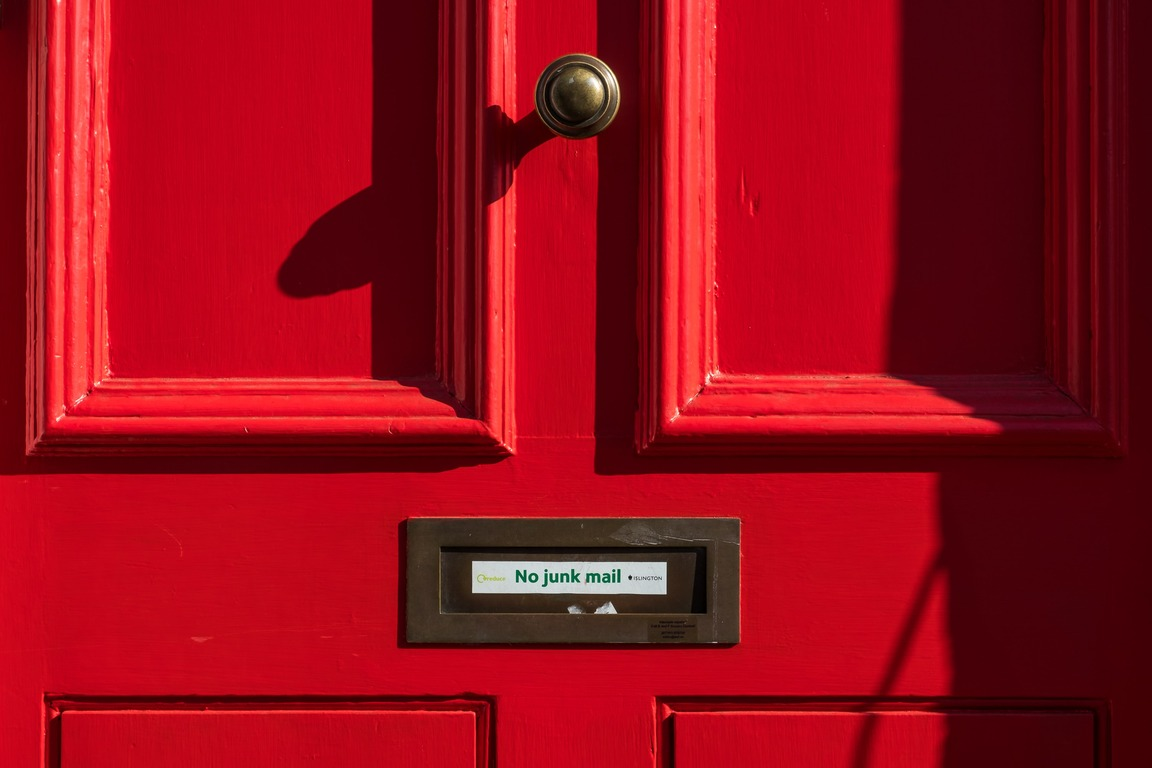

## Introduction
The aim of this project is to build a spam filter for SMS messages using the multinomial Naive Bayes algorithm and a dataset of 5,572 SMS messages that are already classified by humans. The dataset was put together by Tiago A. Almeida and José María Gómez Hidalgo, and it can be downloaded from [this repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection). 

To classify messages as spam or non-spam, the computer:

- Learns how humans classify messages.
- Uses that knowledge to estimate probabilities for new messages being spam or non-spam.
- Classifies a new message based on these values: 
     - the probability for spam is greater — spam,
     - the probability for non-spam is greater — non-spam,
     - the two probability values are equal — we may need a human to classify the message.
     
In other words, our task for this project is to "teach" the computer how to classify messages. 
### Summary of Results
We created a highly accurate spam filter, managing to reach the accuracy of 98.74%, which is almost 20% higher than our initial focus. A few messages classified incorrectly revealed some features in common. The attempt to increase the accuracy even further by making the algorithm sensitive to letter case resulted, just the opposite, in rendering the spam filter 13.5% less efficient.
## Exploring the Dataset

Number of SMS messages: 5,572
Number of missing values in the dataframe: 0

Spam vs. ham (non-spam), %
+-------+------+
| Label |  %   |
+-------+------+
|  ham  | 87.0 |
| spam  | 13.0 |
+-------+------+


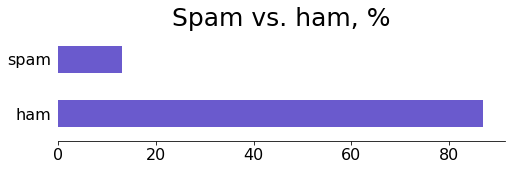

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import operator
from wordcloud import WordCloud, STOPWORDS

sms = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['Label', 'SMS'])

print(f'Number of SMS messages: {sms.shape[0]:,}')
print(f'Number of missing values in the dataframe: {sms.isnull().sum().sum()}\n')

def pretty_print_table(df, substring):
    '''Pretty-prints a table of the result of `value_counts` method (in % and
    rounded) on the `Label` column of an input dataframe. Prints the title of
    the table with an input substring incorporated.
    '''
    print(f'Spam vs. ham {substring}, %')
    spam_ham_pct = round(df['Label'].value_counts(normalize=True)*100, 0)
    print(spam_ham_pct.to_markdown(tablefmt='pretty', headers=['Label', '%']))

# Pretty-printing % of spam and ham messages
pretty_print_table(df=sms, substring='(non-spam)')

# Plotting % of spam and ham messages
spam_pct = round(sms['Label'].value_counts(normalize=True)*100, 0)
fig, ax = plt.subplots(figsize=(8,2))
spam_pct.plot.barh(color='slateblue')
ax.set_title('Spam vs. ham, %', fontsize=25)
ax.set_xlabel(None)
ax.tick_params(axis='both', labelsize=16, left=False)
for side in ['top', 'right', 'left']:
    ax.spines[side].set_visible(False)
plt.show()

sms.head()

## Training and Test Set
To start with, we have to put apart a portion of the entire dataset that we'll use at the end to test how well our spam filter classifies new messages. Hence, we have to split our dataset into 2 parts:
- a training set (80% of the dataset, i.e. 4,458 messages), which we'll use to train the computer how to classify messages,
- a test set (20% of the dataset, i.e. 1,114 messages), which we'll use for a final check.

Let's focus on creating a spam filter that classifies new messages with an accuracy greater than 80%. First, we're going to randomize the dataset to ensure that spam and ham messages are spread properly throughout the dataset.

In [2]:
sms_randomized = sms.sample(frac=1, random_state=1)

# Creating a training set (80%) and a test set (20%)
training_set = sms_randomized[:4458].reset_index(drop=True)
test_set = sms_randomized[4458:].reset_index(drop=True)

# Finding the % of spam and ham in both sets
pretty_print_table(df=training_set, substring='in the training set')
print('\n')
pretty_print_table(df=test_set, substring='in the test set')

Spam vs. ham in the training set, %
+-------+------+
| Label |  %   |
+-------+------+
|  ham  | 87.0 |
| spam  | 13.0 |
+-------+------+


Spam vs. ham in the test set, %
+-------+------+
| Label |  %   |
+-------+------+
|  ham  | 87.0 |
| spam  | 13.0 |
+-------+------+


We see that the percentages of spam/ham messages in each set are representative of those in the whole dataset.

## Data Cleaning
Let's perform some data cleaning to bring the data of the training set in a format that will allow us to extract easily all the necessary information. This format implies a table with the following features:
- the `Label` column (spam/ham), the `SMS` column, and a series of new columns, each representing a unique word from the vocabulary,
- each row describes a single message, with the number of times each word from the vocabulary occurs in it,
- all words in the vocabulary are in lower case,
- punctuation is not considered anymore.

### Letter Case and Punctuation
First, we'll remove the punctuation and bring all the words to lower case:

In [3]:
# Removing punctuation and making all the words lower case
training_set['SMS'] = training_set['SMS'].str.replace('\W', ' ').str.lower()
training_set.head()

,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


### Creating the Vocabulary
Next, we'll create a list of all the unique words that occur in the messages of our training set.

In [4]:
training_set['SMS'] = training_set['SMS'].str.split()
training_set.head(3)

,Label,SMS
0,ham,"[yep, by, the, pretty, sculpture]"
1,ham,"[yes, princess, are, you, going, to, make, me,..."
2,ham,"[welp, apparently, he, retired]"


In [5]:
vocabulary = []
for sms in training_set['SMS']:
    for word in sms:
        vocabulary.append(word)
vocabulary = list(set(vocabulary))
print(f'Number of unique words in the vocabulary of the training set: {len(vocabulary):,}')

Number of unique words in the vocabulary of the training set: 7,783


### The Final Training Set
The last step of data cleaning includes using the vocabulary to make the final data transformation to our training set:

In [6]:
# Creating a dictionary where each key is a unique word from the vocabulary,
# and each value is a list of the frequencies of that word in each message
word_counts_per_sms = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary}
for index, sms in enumerate(training_set['SMS']):
    for word in sms:
        word_counts_per_sms[word][index]+=1
        
word_counts = pd.DataFrame(word_counts_per_sms)
word_counts.head(3)

,50perwksub,upd8,imagine,44,09066362206,sue,happy,biz,frwd,noi,...,overheating,elaine,kanagu,dresser,scratching,10am,rdy,tuesday,ldn,fights
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
training_set_final = pd.concat([training_set, word_counts], axis=1)
training_set_final.head(3)

,Label,SMS,50perwksub,upd8,imagine,44,09066362206,sue,happy,biz,...,overheating,elaine,kanagu,dresser,scratching,10am,rdy,tuesday,ldn,fights
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## The Most Frequent Words in Spam Messages
Before moving forward with creating the spam filter, let's figure out which words are the most popular in spam messages. This information will help us later to obtain more insights when testing the already ready filter.

In [8]:
spam_sms = training_set_final[training_set_final['Label']=='spam']
ham_sms = training_set_final[training_set_final['Label']=='ham']

# Creating a dictionary of words from all spam messages with their frequencies
spam_dict = {}
for sms in spam_sms['SMS']:
    for word in sms:
        if word not in spam_dict:
            spam_dict[word]=0
        spam_dict[word]+=1

# Sorting the dictionary in descending order of word frequencies 
sorted_spam_dict = dict(sorted(spam_dict.items(), key=operator.itemgetter(1), reverse=True))

Now when we have a dictionary of all the words used in spam messages with their corresponding frequencies sorted in descending order, we can extract the 100 most meaningful ones and display them on a word cloud according to their frequency. To obtain an insightful visualization, we have to do a significant amount of manual work: to exclude auxiliary words (*and*, *of*, *inside*, etc.), neutral ones (*day*, *please*, *box*), numbers (1, 16, 50), or words merged with numbers (*150ppm*, *12hrs*, *2lands*). The last category actually looks interesting and definitely spam-like, but showing these words on a word cloud would make them unreadable and, hence, useless. Of course, in this manual part of work, there is some degree of subjectivity, and different people can percept "neutral" words differently. This is a common issue when creating word clouds. Anyway, our approach here will include:
- considering only the most frequent words,
- selecting only the most "suspicious" of them (i.e. non-conservative approach),
- gathering exactly 100 words to visualize.

In [9]:
selected = ['call', 'free', 'stop', 'mobile', 'text', 'claim', 'www', 
            'prize', 'send', 'cash', 'nokia', 'win', 'urgent', 'service',
            'contact', 'com', 'msg', 'chat', 'guaranteed', 'customer', 
            'awarded', 'sms', 'ringtone', 'video', 'rate', 'latest', 
            'award', 'code', 'camera', 'chance', 'apply', 'valid', 'selected',
            'offer', 'tones', 'collection', 'mob', 'network', 'attempt', 
            'bonus', 'delivery', 'weekly', 'club', 'http', 'help', 'dating',
            'vouchers', 'poly', 'auction', 'ltd', 'pounds', 'special',
            'services', 'games', 'await', 'double', 'unsubscribe', 'hot',
            'price', 'sexy', 'camcorder', 'content', 'top', 'calls', 
            'account', 'private', 'winner', 'savamob', 'offers', 'pobox',
            'gift', 'net', 'quiz', 'expires', 'freemsg', 'play', 'ipod',
            'last', 'order', 'anytime', 'congratulations', 'caller', 'points',
            'identifier', 'voucher', 'statement', 'operator', 'real', 
            'mobiles', 'important', 'join', 'rental', 'valued', 'congrats',
            'final', 'enjoy', 'unlimited', 'tv', 'charged', 'sex']

# Extracting only the 100 most frequent spam words with their frequencies
filtered_sorted_spam_dict = {}
for word in selected:
    if word in sorted_spam_dict:
        filtered_sorted_spam_dict[word]=sorted_spam_dict[word] 
        
print(f'The number of the most popular spam words selected: {len(filtered_sorted_spam_dict)}')

The number of the most popular spam words selected: 100


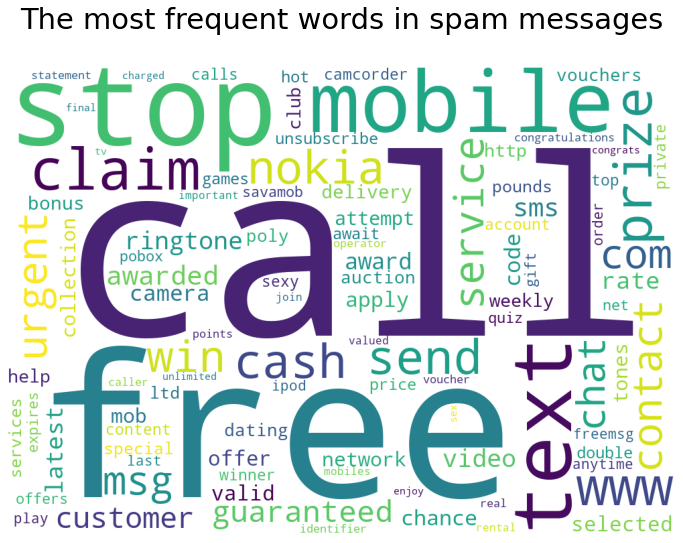

In [10]:
# Creating a word cloud
fig = plt.subplots(figsize=(12,10)) 
wordcloud = WordCloud(width=1000, height=700,
                      background_color='white', 
                      random_state=1).generate_from_frequencies(filtered_sorted_spam_dict)
plt.title('The most frequent words in spam messages\n', fontsize=29)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

The 100 most frequent words of spam messages reveal the following patterns :
- encouraging people to do further actions (*call*, *text*, *send*, *contact*, *help*, *claim*, *apply*),
- promising them something alluring (*free*, *offer*, *prize*, *award*, *special*, *unlimited*, *guaranteed*, *gift*, *bonus*), 
- urging them (*urgent*, *attempt*, *stop*), 
- having sexual context (*dating*, *hot*, *sexy*, *sex*), 
- inviting to visit some web resources (*www*, *http*, *com*, *net*), 
- advertising various digital devices and products (*nokia*, *ringtone*, *video*, *camcorder*, *ipod*, *camera*, *games*).

##  Calculating Constants
Now, let's return to our cleaned training set and start creating the spam filter. 

When a new message comes in, the Naive Bayes algorithm will make the classification based on the probabilities it gets to these two equations:

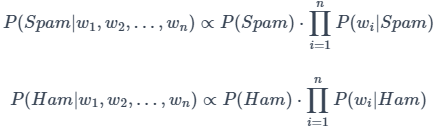

To calculate *P(w<sub>i</sub>|Spam)* and *P(w<sub>i</sub>|Ham)* inside the formulas above:

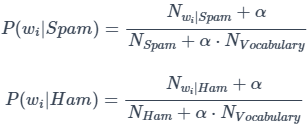

where:
- *N<sub>w<sub>i</sub>|Spam</sub>* — the number of times the word *w<sub>i</sub>* occurs in spam messages,
- *N<sub>w<sub>i</sub>|Ham</sub>* — the number of times the word *w<sub>i</sub>* occurs in ham messages,
- *N<sub>Spam</sub>* — total number of words in spam messages,
- *N<sub>Ham</sub>* — total number of words in ham messages,
- *N<sub>Vocabulary</sub>* — total number of unique words in the vocabulary,
- *α* — a smoothing parameter.

Some of these terms will have the same value for every new message: *P(Spam)*, *P(Ham)*, *N<sub>Spam</sub>*, *N<sub>Ham</sub>*, *N<sub>Vocabulary</sub>*. We'll also use Laplace smoothing and set *α*=1.

Let's calculate these constants:

In [11]:
p_spam = training_set_final['Label'].value_counts()['spam']/len(training_set_final)
p_ham = training_set_final['Label'].value_counts()['ham']/len(training_set_final)

n_spam = 0
n_ham = 0
for i in range(len(training_set_final)):
    row = list(training_set_final.iloc[i].values)
    for j in range(2,len(row)):
        if row[0]=='spam':
            n_spam+=row[j]
        else:
            n_ham+=row[j]
            
n_vocabulary = len(vocabulary)
alpha = 1

print(f'p_spam: {p_spam:.2f}\n'
      f'p_ham: {p_ham:.2f}\n'
      f'n_spam: {n_spam:,}\n'
      f'n_ham: {n_ham:,}\n'
      f'n_vocabulary: {n_vocabulary:,}\n'
      f'alpha: {alpha}')

p_spam: 0.13
p_ham: 0.87
n_spam: 15,190
n_ham: 57,237
n_vocabulary: 7,783
alpha: 1


## Calculating Parameters
The parameters *P(w<sub>i</sub>|Spam)* and *P(w<sub>i</sub>|Ham)* will vary depending on the individual words. However, both probabilities for each individual word remain constant for every new message, since they only depend on the training set. This means that we can use our training set to calculate both probabilities for each word in our vocabulary beforehand, which makes the Naive Bayes algorithm very fast compared to other algorithms. When a new message comes in, most of the needed computations are already done, which enables the algorithm to almost instantly classify the new message.

There are 7,783 words in our vocabulary, hence we'll need to calculate a total of 15,566 probabilities (*P(w<sub>i</sub>|Spam)* and *P(w<sub>i</sub>|Ham)* for each word) using the following equations:

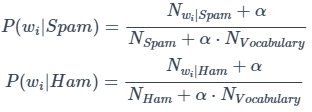

In [12]:
p_wi_spam = {}
p_wi_ham = {}

for word in vocabulary:
    p_wi_spam[word] = (spam_sms[word].sum()+alpha)/(n_spam+alpha*n_vocabulary)
    p_wi_ham[word] = (ham_sms[word].sum()+alpha)/(n_ham+alpha*n_vocabulary)
p_wi_spam['to'].sum()

0.023810560222870324

## Classifying A New Message
Now, we're ready to create the spam filter, which can be understood as a function that:
- Takes in as input a new message.
- Calculates *P(Spam|message)* and *P(Ham|message)* using the following formulas:
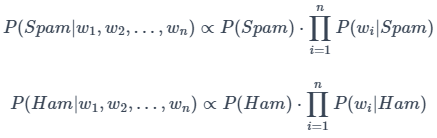
- Compares both values and:
    - if *P(Ham|message)* > *P(Spam|message)*, then the message is classified as ham,
    - if *P(Ham|message)* < *P(Spam|message)*, then the message is classified as spam,
    - if *P(Ham|message)* = *P(Spam|message)*, then the algorithm may request human help.
    
If a new message contains some words that are not in the vocabulary, these words will be simply ignored for calculating the probabilities.

Let's create this function and check it on a couple of messages that are obviously spam or ham:

In [13]:
def classify_test_set(message):
    '''Takes in a message as a string, removes punctuation, and makes all the
    words lower case, calculates P(Spam|message) and P(Ham|message) based on
    the constants and parameters calculated earlier in the project, compares
    the two values and classifies the message as spam or ham, or requires 
    human classification. 
    '''
    message = re.sub('\W', ' ', message)
    message = message.split()
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    for word in message:
        if word in p_wi_spam:
            p_spam_given_message*=p_wi_spam[word]
        if word in p_wi_ham:
            p_ham_given_message*=p_wi_ham[word]
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_spam_given_message > p_ham_given_message:
        return 'spam'
    else:
        return 'needs human classification'

# Testing the function
print(classify_test_set('Do you want to win an amazing super-prize today?'))
print(classify_test_set('Elena, you look super-amazing today!'))

spam
ham


Glad to know that the second message is not just spam! 😀
Anyway, both test messages above contain the words *you*, *amazing*, *super*, and *today*, and the word *Elena* is not in the vocabulary:

In [14]:
'Elena' in vocabulary

False

However, the difference between the two messages is quite evident, and the algorithm managed to distinguish the meaning successfully.
##  Measuring the Spam Filter's Accuracy
Let's check how well the spam filter does on our test set of 1,114 messages. For the algorithm, each message in this dataset is new since we didn't use it for training. The output will be a classification label for every message, which we'll be able to compare with the actual label given by a human. 

In [15]:
test_set['Predicted'] = test_set['SMS'].apply(classify_test_set)
test_set.head()

,Label,SMS,Predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


Now, we can compare the predicted values with the actual ones using the accuracy as a metric:

In [16]:
# Calculating the accuracy of the spam filter
correct = 0
total = len(test_set)        # number of sms in the test set
for row in test_set.iterrows():
    if row[1]['Predicted']==row[1]['Label']:
        correct+=1
accuracy = correct/total*100
print(f'The accuracy of the spam filter: {accuracy:.2f}%')

The accuracy of the spam filter: 98.56%


Hence, our spam filter is much more accurate than we even expected (we initially aimed for the accuracy of over 80%) and can be successfully used to sort out incoming messages as spam or ham.  
## Wrongly Classified Messages
There are a few messages, though, that were classified incorrectly. Let's take a look at them and try  to understand why in those cases the algorithm reached the wrong conclusions.

In [17]:
false_spam = test_set[(test_set['Predicted']=='spam')&(test_set['Label']=='ham')].reset_index(drop=True)
false_ham = test_set[(test_set['Predicted']=='ham')&(test_set['Label']=='spam')].reset_index(drop=True)
unclear = test_set[test_set['Predicted']=='needs human classification'].reset_index(drop=True)

print('Total number of wrongly classified messages: ', len(false_spam)+len(false_ham)+len(unclear))
print('_________________________________________________________________________\n')
print('FALSE SPAM MESSAGES:')
for row in false_spam.iterrows():
    print(f'{row[0]+1}. ', row[1]['SMS'])
print('_________________________________________________________________________\n')
print('FALSE HAM MESSAGES:')
for row in false_ham.iterrows():
    print(f'{row[0]+1}. ', row[1]['SMS'])
print('_________________________________________________________________________\n')
print('UNCLEAR MESSAGES:')
for row in unclear.iterrows():
    print(f'{row[0]+1}. ', row[1]['SMS'])
print('_________________________________________________________________________')

Total number of wrongly classified messages:  16
_________________________________________________________________________

FALSE SPAM MESSAGES:
1.  I liked the new mobile
2.  Unlimited texts. Limited minutes.
3.  Miss call miss call khelate kintu opponenter miss call dhorte lage. Thats d rule. One with great phone receiving quality wins.
4.  No calls..messages..missed calls
5.  Yup next stop.
6.  Madam,regret disturbance.might receive a reference check from DLF Premarica.kindly be informed.Rgds,Rakhesh,Kerala.
7.  Ok... Ur typical reply...
_________________________________________________________________________

FALSE HAM MESSAGES:
1.  Not heard from U4 a while. Call me now am here all night with just my knickers on. Make me beg for it like U did last time 01223585236 XX Luv Nikiyu4.net
2.  You won't believe it but it's true. It's Incredible Txts! Reply G now to learn truly amazing things that will blow your mind. From O2FWD only 18p/txt
3.  Oh my god! I've found your number again! I

- In very rare occasions, ham messages can be incorrectly detected as spam when they are very short (considering also that some of the words from a new message can be absent in the vocabulary) and, at the same time, contain suspicious ad-style words, like *unlimited*, *phone*, *calls*, *messages*, *contact*, *sent*, that were previously found mostly in spam messages and that we observed, indeed, earlier on the word cloud. In addition, false spam messages, being very short, can contain seemingly neutral words (like *July*) but which were found in the training set only 1-2 times and, by coincidence, in spam messages.
- Spam messages incorrectly detected as ham tend to be rather long and have a high percentage of "normal" words, which allows them to override the system. They usually contain contact details, websites, mentioning sums of money, words like *asap*, or they just can, in case of being short, consist of the words absent in the vocabulary.
- The message that was not identified at all (and originally it was a ham message) is quite long and characterized by heavy usage of slang and abbreviations most probably absent in the vocabulary. As for the other words, the majority of them look neutral and could have been detected both in spam and ham messages. There are, though, some potentially suspicious words (*saved*, *boost*, *secret*, *energy*, *instantly*) that increased the probability of spam for this message up to being equal to that of ham.

## Experiment: Making the Algorithm Case-Sensitive
Now that we created a highly accurate spam filter, let's try as an experiment to tune some steps in it and observe the result. The idea is to figure out if making the filtering process more complex can increase the spam filter accuracy even further. We can think of the following adjustments:
- increasing the training set size (decreasing, however, the one of the test set) to train the algorithm more,
- selecting alpha different than 1,
- preserving punctuation (the word *win* and *win!!!* can appear in rather different contexts),
- making the algorithm sensitive to letter case (for example, *SECRET* seems to be more spam-like than *secret*).

Let's try the last approach and see what will happen. For making things faster, we'll gather all the previous code necessary for this task in a long code cell below, remove the steps related to making the words lower case, and add the suffix *_exp* (meaning *experiment*) to all the variables and the function:

In [18]:
training_set_exp = sms_randomized[:4458].reset_index(drop=True)
test_set_exp = sms_randomized[4458:].reset_index(drop=True)
training_set_exp['SMS'] = training_set_exp['SMS'].str.replace('\W', ' ')

vocabulary_exp = []
for sms in training_set_exp['SMS']:
    for word in sms:
        vocabulary_exp.append(word)
vocabulary_exp = list(set(vocabulary_exp))

word_counts_per_sms_exp = {unique_word: [0] * len(training_set_exp['SMS']) for unique_word in vocabulary_exp}
for index, sms in enumerate(training_set_exp['SMS']):
    for word in sms:
        word_counts_per_sms_exp[word][index]+=1
        
word_counts_exp = pd.DataFrame(word_counts_per_sms_exp)

training_set_final_exp = pd.concat([training_set_exp, word_counts_exp], axis=1)
    
spam_sms_exp = training_set_final_exp[training_set_final_exp['Label']=='spam']
ham_sms_exp = training_set_final_exp[training_set_final_exp['Label']=='ham']

p_spam_exp = training_set_final_exp['Label'].value_counts()['spam']/len(training_set_final_exp)
p_ham_exp = training_set_final_exp['Label'].value_counts()['ham']/len(training_set_final_exp)

n_spam_exp = 0
n_ham_exp = 0
for i in range(len(training_set_final_exp)):
    row = list(training_set_final_exp.iloc[i].values)
    for j in range(2,len(row)):
        if row[0]=='spam':
            n_spam_exp+=row[j]
        else:
            n_ham_exp+=row[j]
            
n_vocabulary_exp = len(vocabulary_exp)
alpha = 1

p_wi_spam_exp = {}
p_wi_ham_exp = {}
for word in vocabulary_exp:
    p_wi_spam_exp[word] = (spam_sms_exp[word].sum()+alpha)/(n_spam_exp+alpha*n_vocabulary_exp)
    p_wi_ham_exp[word] = (ham_sms_exp[word].sum()+alpha)/(n_ham_exp+alpha*n_vocabulary_exp)
    
def classify_test_set_exp(message):
    message = re.sub('\W', ' ', message)
    message = message.split()
    p_spam_given_message_exp = p_spam_exp
    p_ham_given_message_exp = p_ham_exp
    for word in message:
        if word in p_wi_spam_exp:
            p_spam_given_message_exp*=p_wi_spam_exp[word]
        if word in p_wi_ham_exp:
            p_ham_given_message_exp*=p_wi_ham_exp[word]
    if p_ham_given_message_exp > p_spam_given_message_exp:
        return 'ham'
    elif p_spam_given_message_exp > p_ham_given_message_exp:
        return 'spam'
    else:
        return 'needs human classification'
    
test_set_exp['Predicted'] = test_set_exp['SMS'].apply(classify_test_set_exp)

correct_exp = 0
total_exp = len(test_set_exp)

for row in test_set_exp.iterrows():
    if row[1]['Predicted']==row[1]['Label']:
        correct_exp+=1
accuracy_exp = correct_exp/total_exp*100
print(f'The accuracy of the spam filter: {accuracy_exp:.2f}%')

The accuracy of the spam filter: 85.28%


We see that the experiment on making the filtering system more complex by introducing letter case sensitivity ended up rendering our spam filter much less efficient in labeling a new message (the accuracy has dropped by 13.5%), even though it's still more efficient than 80% of accuracy that we aimed at the beginning. It seems that the letter case doesn't really make any valuable difference when it comes to distinguishing between spam and ham messages. Hence, for further classifying new messages, we can approve the previous spam filter with 98.74% of accuracy.
## Conclusion
In this project, we created a highly accurate spam filter based on the multinomial Naive Bayes algorithm and a dataset of labeled 5,572 SMS. The spam filter takes in a new message and classifies it as spam or ham. We managed to reach an accuracy of 98.74%, which is almost 20% higher than our initial focus. Below are some additional conclusions and insights from this project:
-	A few messages classified incorrectly have some features in common. False spam messages tend to be very short, have the words absent in the vocabulary, contain typical spam-like words, or neutral words previously detected, by coincidence, only in spam messages. False ham messages tend to be rather long and have a high percentage of neutral words or the words absent in the vocabulary. In the undefined messages, we can expect an approximately proportional mixture of neutral and spam-like words.
-	The attempt to increase the accuracy even further by making the algorithm sensitive to letter case resulted, just the opposite, in rendering the spam filter much less efficient, with the accuracy dropped by 13.5%. It seems that the letter case doesn't make any valuable difference when it comes to distinguishing between spam and ham messages. 
-	The 100 most popular meaningful spam-prone words revealed the following patterns: encouraging people to do further actions, promising them something alluring, urging them, having sexual context, inviting to visit some web resources, advertising various digital devices and products.